In [1]:
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from model import *
from trainer import *

## Initialize data

In [2]:
corpus = data.Corpus('./data/ptb')
ntokens = len(corpus.dictionary)

## Overhead stuff

Helper functions for batching, resetting hidden states, etc.

In [3]:
# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 4
lr = 0.02
warmup_steps = 10
decay_factor = 0.5
smoothing = 0.05

epochs = 100
log_interval = 150  # Print log every `log_interval` batches

In [4]:
# Model hyperparameters
embed_size = 512
encode_size = 256
h_size = 256
decode_size = 256
n_enc_layers = 1
attn_rnn_layers = 1
n_dec_layers = 0
smooth_align = True
align_location = False
skip_connections = False

The learning rate scheduler sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

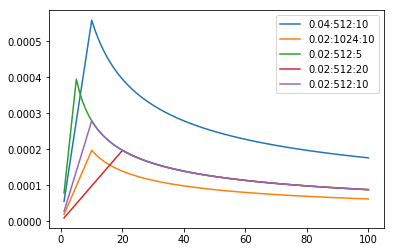

In [5]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps*2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.4g:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps*2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps),
])

## Initialize model, criterion, optimizer, and learning rate scheduler

In [6]:
model = RNNModel(
    src_vocab = ntokens, tgt_vocab = ntokens, embed_size = embed_size,
    h_size = h_size, encode_size = encode_size, decode_size = decode_size,
    n_enc_layers = n_enc_layers, attn_rnn_layers = attn_rnn_layers,
    n_dec_layers = n_dec_layers, align_location = align_location,
    skip_connections = skip_connections, smooth_align = smooth_align,
    dropout = dropout
)
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
eval_criterion = LabelSmoothing(ntokens, smoothing = 0)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, decay_factor, optimizer)
# Reference
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 9464337


## Train
Ready the data

In [11]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([12562, 74]), torch.Size([7376, 10]), torch.Size([8243, 10]))

Train and evaluate

In [ ]:
WIDTH = 112
CAUSES = ['output', 'grad']
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:0.4g}{}'.format(epoch+1, epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, train_loss, data, targets, states, nstates = train(
        model, train_data, batch_size, seq_len, ntokens,
        criterion, optimizer, lr_scheduler, clip, log_interval
    )
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(
        model, val_data, eval_batch_size, 
        seq_len, ntokens, eval_criterion,
        save_wts = False
    )
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:6.2f} sec | train_loss: {:5.2f} | train_perp: {:6.2f} | valid_loss: {:5.2f} | valid_perp.: {:6.2f}'.format(
        elapsed, train_loss, np.exp(train_loss), val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch   1/100) lr = 2.795e-05 (warmup)
 b 150/713 >> 1952.3 ms/b | lr:  2.8e-05 | grad norm: 2.70 | max abs grad:   0.114 | loss: 7.08 | perp.: 1184.49
 b 300/713 >> 1954.2 ms/b | lr:  2.8e-05 | grad norm: 2.34 | max abs grad:   0.099 | loss: 6.13 | perp.: 461.23
 b 450/713 >> 1909.2 ms/b | lr:  2.8e-05 | grad norm: 2.26 | max abs grad:   0.098 | loss: 6.05 | perp.: 422.25
 b 600/713 >> 1947.8 ms/b | lr:  2.9e-05 | grad norm: 1.92 | max abs grad:   0.070 | loss: 5.99 | perp.: 400.42
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1381.48 sec | train_loss:  6.25 | train_perp: 517.11 | valid_loss:  5.87 | valid_perp.: 354.24


Epoch   2/100) lr = 5.59e-05 (warmup)
 b 150/717 >> 1941.8 ms/b | lr:  4.9e-05 | grad norm: 2.46 | max abs grad:   0.096 | loss: 5.94 | perp.: 378.96
 b 300/717 >> 1933.9 ms/b | lr:  5.4e-05 | grad norm: 1.89 | max abs grad:   0.068 | loss: 5.86 | perp.: 349.04
 b 450/717 >> 1967.2 ms/b 

 b 150/713 >> 2057.6 ms/b | lr:  0.00025 | grad norm: 5.80 | max abs grad:   0.572 | loss: 3.99 | perp.:  54.31
 b 300/713 >> 2058.9 ms/b | lr:  0.00027 | grad norm: 11.21 | max abs grad:   1.808 | loss: 3.94 | perp.:  51.57
 b 450/713 >> 2057.5 ms/b | lr:  0.00027 | grad norm: 11.77 | max abs grad:   2.113 | loss: 3.97 | perp.:  53.01
 b 600/713 >> 2117.0 ms/b | lr:  0.00025 | grad norm: 5.87 | max abs grad:   0.735 | loss: 3.94 | perp.:  51.36
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1487.12 sec | train_loss:  3.99 | train_perp:  54.05 | valid_loss:  4.01 | valid_perp.:  54.97


Epoch  12/100) lr = 0.0002552
 b 150/720 >> 2137.5 ms/b | lr:  0.00026 | grad norm: 13.24 | max abs grad:   3.143 | loss: 3.88 | perp.:  48.63
 b 300/720 >> 2135.3 ms/b | lr:  0.00028 | grad norm: 41.12 | max abs grad:   8.318 | loss: 3.88 | perp.:  48.21
 b 450/720 >> 2156.7 ms/b | lr:  0.00022 | grad norm: 7.37 | max abs g

 b 300/719 >> 2258.7 ms/b | lr:  0.00019 | grad norm: 42.20 | max abs grad:   6.193 | loss: 3.56 | perp.:  35.11
 b 450/719 >> 2314.9 ms/b | lr:   0.0002 | grad norm: 81.95 | max abs grad:  13.802 | loss: 3.57 | perp.:  35.67
 b 600/719 >> 2350.2 ms/b | lr:  0.00016 | grad norm: 18.22 | max abs grad:   2.878 | loss: 3.61 | perp.:  36.81
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1674.67 sec | train_loss:  3.63 | train_perp:  37.72 | valid_loss:  3.63 | valid_perp.:  37.88


Epoch  22/100) lr = 0.0001884
 b 150/716 >> 2367.1 ms/b | lr:  0.00019 | grad norm: 51.37 | max abs grad:   8.043 | loss: 3.62 | perp.:  37.16
 b 300/716 >> 2324.8 ms/b | lr:  0.00019 | grad norm: 112.91 | max abs grad:  25.686 | loss: 3.56 | perp.:  35.03
 b 450/716 >> 2319.5 ms/b | lr:   0.0002 | grad norm: 69.61 | max abs grad:  12.612 | loss: 3.58 | perp.:  35.97
 b 600/716 >> 2386.1 ms/b | lr:  0.00019 | grad norm: 75.68 | max a

 b 300/723 >> 2513.1 ms/b | lr:  0.00017 | grad norm: 254.81 | max abs grad:  59.044 | loss: 3.60 | perp.:  36.54
 b 450/723 >> 2350.8 ms/b | lr:  0.00017 | grad norm: 112.52 | max abs grad:  17.972 | loss: 3.50 | perp.:  33.07
 b 600/723 >> 2450.1 ms/b | lr:  0.00015 | grad norm: 50.13 | max abs grad:  10.018 | loss: 3.59 | perp.:  36.18
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1754.88 sec | train_loss:  3.61 | train_perp:  36.81 | valid_loss:  3.55 | valid_perp.:  34.69


Epoch  32/100) lr = 0.0001563
 b 150/728 >> 2406.6 ms/b | lr:  0.00015 | grad norm: 92.34 | max abs grad:  16.867 | loss: 3.52 | perp.:  33.87
 b 300/728 >> 2445.9 ms/b | lr:  0.00014 | grad norm: 45.72 | max abs grad:   8.069 | loss: 3.52 | perp.:  33.67
 b 450/728 >> 2398.0 ms/b | lr:  0.00016 | grad norm: 131.21 | max abs grad:  24.883 | loss: 3.65 | perp.:  38.47
 b 600/728 >> 2490.8 ms/b | lr:  0.00014 | grad norm: 102.17 | ma

 b 300/709 >> 2498.0 ms/b | lr:  0.00014 | grad norm: 104.88 | max abs grad:  18.017 | loss: 3.54 | perp.:  34.43
 b 450/709 >> 2591.5 ms/b | lr:  0.00014 | grad norm: 102.92 | max abs grad:  15.555 | loss: 3.62 | perp.:  37.32
 b 600/709 >> 3050.6 ms/b | lr:  0.00013 | grad norm: 201.03 | max abs grad:  40.357 | loss: 3.54 | perp.:  34.52
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1963.54 sec | train_loss:  3.61 | train_perp:  36.96 | valid_loss:  3.51 | valid_perp.:  33.50


Epoch  42/100) lr = 0.0001364
 b 150/718 >> 3138.9 ms/b | lr:  0.00012 | grad norm: 75.61 | max abs grad:  14.083 | loss: 3.56 | perp.:  35.28
 b 300/718 >> 3075.2 ms/b | lr:  0.00011 | grad norm: 166.74 | max abs grad:  35.100 | loss: 3.54 | perp.:  34.48
 b 450/718 >> 3180.6 ms/b | lr:  0.00014 | grad norm: 72.68 | max abs grad:  13.805 | loss: 3.55 | perp.:  34.97
 b 600/718 >> 3069.5 ms/b | lr:  0.00015 | grad norm: 83.54 | ma

 b 300/717 >> 3149.9 ms/b | lr:  0.00011 | grad norm: 48.63 | max abs grad:   8.894 | loss: 3.49 | perp.:  32.88
 b 450/717 >> 3183.6 ms/b | lr:  0.00013 | grad norm: 534.05 | max abs grad: 115.757 | loss: 3.47 | perp.:  32.17
 b 600/717 >> 3209.8 ms/b | lr:  0.00012 | grad norm: 2248.28 | max abs grad: 473.084 | loss: 3.52 | perp.:  33.68
----------------------------------------------------------------------------------------------------------------
Elapsed time: 2294.54 sec | train_loss:  3.55 | train_perp:  34.66 | valid_loss:  3.55 | valid_perp.:  34.85


Epoch  52/100) lr = 0.0001226
 b 150/727 >> 3177.4 ms/b | lr:  0.00011 | grad norm: 62.15 | max abs grad:  10.124 | loss: 3.52 | perp.:  33.71
 b 300/727 >> 3211.7 ms/b | lr:  0.00013 | grad norm: 112.51 | max abs grad:  20.057 | loss: 3.51 | perp.:  33.54
 b 450/727 >> 3196.4 ms/b | lr:  0.00013 | grad norm: 117.34 | max abs grad:  16.610 | loss: 3.51 | perp.:  33.46
 b 600/727 >> 3030.3 ms/b | lr:  0.00014 | grad norm: 104.40 | 

In [ ]:
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    enc_states, attn_states, dec_states = states
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoder(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoder(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])

In [ ]:
test_loss = evaluate(test_data, save_wts = True)
print('test_loss: {:5.2f} | test_perplexity: {:5.2f}'.format(
    test_loss, np.exp(test_loss)
))

## Evaluate predictions

In [ ]:
nb = 4
model.eval(save_wts = True)
# Get some data from a random point in the test_data set
states = model.init_states(nb)
data, targets = get_batch(test_data, 120, seq_len, evaluate = True)
data = data[:,:nb].contiguous()
targets = targets.view(seq_len, -1)[:,:nb].contiguous()

In [ ]:
# Run the model forward
output, states = model(data, states)
# Convert the output log probabilities to normal probabilities
output = output.exp()
# Get the argmax of each step in the output
output_p, output_idx = output.max(dim = -1)

Compare the predicted output word indices to the targets

In [ ]:
targets = targets.t()
output_idx = output_idx.t()
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

## Visualizations

Some basic weight heat maps to start:

In [ ]:
embed_wts = np.array(model.embedding.weight.data)
embed_norm = (embed_wts - embed_wts.mean()) / (embed_wts.max() - embed_wts.min())
plt.imshow(embed_norm, aspect = 'auto', cmap = 'jet')
plt.xlabel('dim'); plt.ylabel('word index');
plt.title('Embedding layer')
plt.colorbar()
embed_wts.shape

In [ ]:
attn = model.attn

In [ ]:
attn_wts = np.array(attn.attention.weight.data)
attn_norm = (attn_wts - attn_wts.mean()) / (attn_wts.max() - attn_wts.min())
plt.imshow(attn_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_input+d_state'); plt.ylabel('d_output')
plt.title('Output attention sublayer (in attention mechanism)')
plt.colorbar()
attn_wts.shape

Sequence attention visualization by mapping the alignment weights (in the attention mechanism) at each step of the input:

In [ ]:
cols = 2
rows = nb//cols
fig, axs = plt.subplots(rows, cols, figsize = (30, 20))
for b in range(nb):
    wts = attn.attn_wts[:,b,:]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    r = b // cols
    c = b % cols
    ax = axs[r, c]
    im = ax.imshow(wts, aspect = 'auto', cmap = 'jet')
    # Fix labels
    xlabels = list(targets[b].data)
    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Targets')
    ylabels = list(data[:,b].data)
    ax.set_yticks(range(seq_len))
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Inputs')
    ax.set_title('Example %d' % b)
    fig.colorbar(im, ax = ax)
plt.show()